In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os
import sys

src_dir = './../../src/'
sys.path[0] = src_dir

import matplotlib.pyplot as plt

import glob

import numpy as np
import pandas as pd
import seaborn as sns

from collections import OrderedDict

from access_biology_data import meta, relations, properties
from access_literature_data import medline
from access_science_shared import standardizer 

In [4]:
sys.path.append('./../src/')
from aging_tools import inout, export
from access_aging_data import earlier_studies, chaperome, companions, sequencing

from access_science_shared import standardizer

In [5]:
from scipy.stats import mannwhitneyu

In [6]:
from narrative import nar181026_heat_confidence_genes
from narrative import nar181205_networks

In [7]:
from scipy.stats import spearmanr
from natsort import natsorted

In [8]:
pval = 'dummy'

In [9]:
save_images = True

In [10]:
outfolder = '200609_transcript_length_lambda_with_confidence'

In [11]:
renamer = {
        'Adrenal': 'Adrenal Gland', 
        'BAT': 'Brown adipose tissue', 
        'Blood': 'Blood', 
        'Brain': 'Frontal cortex', 
        'Esophagus': 'Esophagus', 
        'GutEP': 'Gut epithelium', 
        'Heart': 'Heart',
        'Kidney': 'Kidney', 
        'LI': 'Large intestine', 
        'Liver': 'Liver', 
        'Lung': 'Lung', 
        'MuscSat': 'Muscle', 
        'SI': 'Small intestine', 
        'Skin': 'Skin',
        'Stomach': 'Stomach', 
        'WAT': 'White adipose tissue', 
        'Cerebellum': 'Cerebellum'}

In [12]:
ref_genes = standardizer.reference_genes(10090, 'orp')

/Users/tstoeger/opt/miniconda3/envs/aging/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [13]:
pr = properties.genbank_validated_rna(10090)[
    ['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']
].rename(columns={
    'Genbank_validated_RNA: full_SumACGT': 'length'
})

pr.loc[:, 'log_length'] = np.log10(pr['length'])
pr = pr[pr['gene_ncbi'].isin(ref_genes)]

In [14]:
all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
    detection_column='padj')
all_de['tissue'] = all_de['tissue'].replace(renamer)


tissues_to_consider = renamer.values()

all_de = all_de[
    (all_de['tissue'].isin(tissues_to_consider)) & 
    (all_de['pfu']==0) &
    (all_de['gene_ncbi'].isin(ref_genes)) & 
    (all_de['padj'].notnull()) &
    (all_de['younger']==4)
]


In [15]:
conditions = natsorted(all_de['condition'].unique())

In [16]:
out = pd.DataFrame(index=conditions, columns=[
    'corr', 'pval', 'increase', 'decrease'
]).rename_axis('condition')

In [17]:
for condition in conditions:
    d = all_de[
        (all_de['de_unit']=='both') & (all_de['condition']==condition)
    ]

    d = d[['gene_ncbi', 'o_over_y', 'padj']].dropna()
    d = pd.merge(d, pr)
    
    
    
    
    f_increase = (d['o_over_y']>0) & (d['padj']<0.05)
    f_decrease = (d['o_over_y']<0) & (d['padj']<0.05)

    if any(f_increase) & any(f_decrease):
        delta = d.loc[f_increase, 'length'].median() - d.loc[f_decrease, 'length'].median()


#         res = dict()
#         res['tissue'] = tissue
#         res['age'] = age
#         res['rho'] = delta
#         res['pval'] = pval
#         res['animals'] = animals

#         agg.append(res)
    
    

#     r, p = spearmanr(d['log_length'], d['o_over_y'])
#     d = d.set_index('gene_ncbi')

        out.loc[condition, 'corr'] = delta
        out.loc[condition, 'pval'] = pval
        out.loc[condition, 'increase'] = d.loc[f_increase, 'length'].median()
        out.loc[condition, 'decrease'] = d.loc[f_decrease, 'length'].median()
        
        out.loc[condition, 'n_increase'] = sum(f_increase)
        out.loc[condition, 'n_decrease'] = sum(f_decrease)

In [18]:
out

,corr,pval,increase,decrease,n_increase,n_decrease
condition,,,,,,
Adrenal_0_4_9,-1239,dummy,3072,4311,23.0,1.0
Adrenal_0_4_12,-1230.75,dummy,2827.25,4058,296.0,59.0
Adrenal_0_4_18,17.75,dummy,3706,3688.25,467.0,288.0
Adrenal_0_4_24,-926,dummy,2983,3909,331.0,170.0
BAT_0_4_9,175.5,dummy,3608,3432.5,2.0,1.0
...,...,...,...,...,...,...
Stomach_0_4_24,-4649,dummy,915,5564,4.0,3.0
WAT_0_4_9,-632,dummy,2986,3618,7.0,54.0
WAT_0_4_12,-677,dummy,2484,3161,17.0,42.0


In [19]:
out = out.reset_index()

In [20]:
out = pd.merge(out, all_de[['condition', 'younger', 'older']].drop_duplicates())

In [21]:
out['ratio'] = out['decrease'] / out['increase']

In [22]:
out[out['older']==24].dropna(subset=['corr']).median()

corr         -2032.500000
increase      2009.500000
decrease      4163.500000
n_increase      46.000000
n_decrease      49.000000
younger          4.000000
older           24.000000
ratio            2.007935
dtype: float64

In [23]:
out[out['older']==24].dropna(subset=['corr'])

,condition,corr,pval,increase,decrease,n_increase,n_decrease,younger,older,ratio
3,Adrenal_0_4_24,-926,dummy,2983,3909,331.0,170.0,4.0,24.0,1.31043
7,BAT_0_4_24,-1577,dummy,2887,4464,176.0,92.0,4.0,24.0,1.54624
11,Blood_0_4_24,-3060.25,dummy,1287,4347.25,68.0,14.0,4.0,24.0,3.37782
19,Cerebellum_0_4_24,-2509,dummy,1654.5,4163.5,24.0,1.0,4.0,24.0,2.51647
23,Esophagus_0_4_24,-3771,dummy,2009.5,5780.5,46.0,58.0,4.0,24.0,2.87659
27,GutEP_0_4_24,-3363.75,dummy,1745.75,5109.5,54.0,68.0,4.0,24.0,2.92682
35,Kidney_0_4_24,-3281,dummy,1560,4841,721.0,847.0,4.0,24.0,3.10321
39,LI_0_4_24,-2032.5,dummy,2016.5,4049,25.0,45.0,4.0,24.0,2.00793
43,Liver_0_4_24,-768.5,dummy,1798.5,2567,8.0,1.0,4.0,24.0,1.4273
47,Lung_0_4_24,310.75,dummy,3811.75,3501,56.0,56.0,4.0,24.0,0.918476


In [24]:
out[out['older']==9].dropna(subset=['corr']).median()

corr          -922.250000
increase      3029.000000
decrease      3525.250000
n_increase       5.500000
n_decrease       2.500000
younger          4.000000
older            9.000000
ratio            1.307487
dtype: float64

In [25]:
out[out['older']==12].dropna(subset=['corr']).median()

corr         -1460.500000
increase      2179.000000
decrease      3909.000000
n_increase       9.000000
n_decrease       4.000000
younger          4.000000
older           12.000000
ratio            1.793942
dtype: float64

In [26]:
out[out['older']==18].dropna(subset=['corr']).median()

corr         -1796.250000
increase      2583.000000
decrease      3705.250000
n_increase      29.000000
n_decrease      19.000000
younger          4.000000
older           18.000000
ratio            1.623759
dtype: float64

In [27]:
helper = out.copy()

In [28]:
helper['total'] = helper['n_increase'] + helper['n_decrease']

In [29]:
helper

,condition,corr,pval,increase,decrease,n_increase,n_decrease,younger,older,ratio,total
0,Adrenal_0_4_9,-1239,dummy,3072,4311,23.0,1.0,4.0,9.0,1.40332,24.0
1,Adrenal_0_4_12,-1230.75,dummy,2827.25,4058,296.0,59.0,4.0,12.0,1.43532,355.0
2,Adrenal_0_4_18,17.75,dummy,3706,3688.25,467.0,288.0,4.0,18.0,0.99521,755.0
3,Adrenal_0_4_24,-926,dummy,2983,3909,331.0,170.0,4.0,24.0,1.31043,501.0
4,BAT_0_4_9,175.5,dummy,3608,3432.5,2.0,1.0,4.0,9.0,0.951358,3.0
...,...,...,...,...,...,...,...,...,...,...,...
63,Stomach_0_4_24,-4649,dummy,915,5564,4.0,3.0,4.0,24.0,6.08087,7.0
64,WAT_0_4_9,-632,dummy,2986,3618,7.0,54.0,4.0,9.0,1.21165,61.0
65,WAT_0_4_12,-677,dummy,2484,3161,17.0,42.0,4.0,12.0,1.27254,59.0
66,WAT_0_4_18,-1023,dummy,2583,3606,37.0,30.0,4.0,18.0,1.39605,67.0


In [30]:
# add addtional labels
helper = pd.merge(
    helper.reset_index(),
    all_de[['condition', 'tissue', 'younger', 'older']].drop_duplicates()
)

In [31]:
helper

,index,condition,corr,pval,increase,decrease,n_increase,n_decrease,younger,older,ratio,total,tissue
0,0,Adrenal_0_4_9,-1239,dummy,3072,4311,23.0,1.0,4.0,9.0,1.40332,24.0,Adrenal Gland
1,1,Adrenal_0_4_12,-1230.75,dummy,2827.25,4058,296.0,59.0,4.0,12.0,1.43532,355.0,Adrenal Gland
2,2,Adrenal_0_4_18,17.75,dummy,3706,3688.25,467.0,288.0,4.0,18.0,0.99521,755.0,Adrenal Gland
3,3,Adrenal_0_4_24,-926,dummy,2983,3909,331.0,170.0,4.0,24.0,1.31043,501.0,Adrenal Gland
4,4,BAT_0_4_9,175.5,dummy,3608,3432.5,2.0,1.0,4.0,9.0,0.951358,3.0,Brown adipose tissue
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,63,Stomach_0_4_24,-4649,dummy,915,5564,4.0,3.0,4.0,24.0,6.08087,7.0,Stomach
64,64,WAT_0_4_9,-632,dummy,2986,3618,7.0,54.0,4.0,9.0,1.21165,61.0,White adipose tissue
65,65,WAT_0_4_12,-677,dummy,2484,3161,17.0,42.0,4.0,12.0,1.27254,59.0,White adipose tissue
66,66,WAT_0_4_18,-1023,dummy,2583,3606,37.0,30.0,4.0,18.0,1.39605,67.0,White adipose tissue


In [32]:
def nice_plot(h):
    t = h.copy()
    
    tissue_dict = {
        'Adrenal': 'Adrenal gland',
        'BAT': 'Brown adipose tissue',
        'Blood': 'Blood',
        'Brain': 'Frontal cortex',
        'Cerebellum': 'Cerebellum',
        'Esophagus': 'Esophagus',
        'GutEP': 'Gut epithelium',
        'Heart': 'Heart',
        'Kidney': 'Kidney',
        'LI': 'Large intestine',
        'Liver': 'Liver',
        'Lung': 'Lung',
        'MuscSat': 'Muscle',
        'SI': 'Small intestine',
        'Skin': 'Skin',
        'Stomach': 'Stomach',
        'WAT': 'White adipose tissue'
    }
    
    t = t.rename(index=tissue_dict)
    t = t.sort_index()
    
    plt.figure(figsize=(4, 5))


    sns.heatmap(
        t, 
        cmap='YlOrBr', 
        annot=True,
        vmin=0,
        vmax=500
    )

In [33]:
helper

,index,condition,corr,pval,increase,decrease,n_increase,n_decrease,younger,older,ratio,total,tissue
0,0,Adrenal_0_4_9,-1239,dummy,3072,4311,23.0,1.0,4.0,9.0,1.40332,24.0,Adrenal Gland
1,1,Adrenal_0_4_12,-1230.75,dummy,2827.25,4058,296.0,59.0,4.0,12.0,1.43532,355.0,Adrenal Gland
2,2,Adrenal_0_4_18,17.75,dummy,3706,3688.25,467.0,288.0,4.0,18.0,0.99521,755.0,Adrenal Gland
3,3,Adrenal_0_4_24,-926,dummy,2983,3909,331.0,170.0,4.0,24.0,1.31043,501.0,Adrenal Gland
4,4,BAT_0_4_9,175.5,dummy,3608,3432.5,2.0,1.0,4.0,9.0,0.951358,3.0,Brown adipose tissue
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,63,Stomach_0_4_24,-4649,dummy,915,5564,4.0,3.0,4.0,24.0,6.08087,7.0,Stomach
64,64,WAT_0_4_9,-632,dummy,2986,3618,7.0,54.0,4.0,9.0,1.21165,61.0,White adipose tissue
65,65,WAT_0_4_12,-677,dummy,2484,3161,17.0,42.0,4.0,12.0,1.27254,59.0,White adipose tissue
66,66,WAT_0_4_18,-1023,dummy,2583,3606,37.0,30.0,4.0,18.0,1.39605,67.0,White adipose tissue


In [34]:
incr = helper.pivot(index='tissue', columns='older', values='n_increase').fillna(0).astype(int)

In [35]:
decr = helper.pivot(index='tissue', columns='older', values='n_decrease').fillna(0).astype(int)

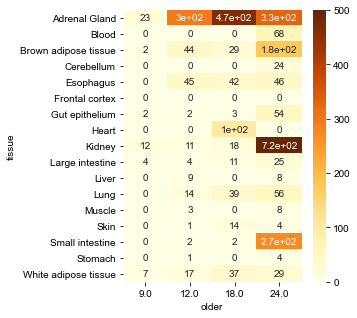

In [36]:
nice_plot(
    incr
)

if save_images:
    export.export_image('{}/n_increased.pdf'.format(outfolder))



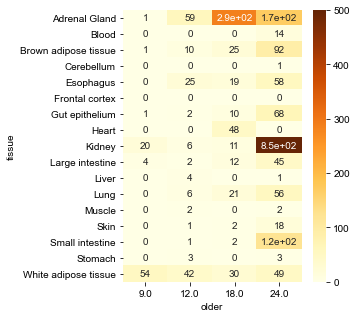

In [37]:
nice_plot(
    decr
)

if save_images:
    export.export_image('{}/n_decreased.pdf'.format(outfolder))




In [38]:
incr

older,9.0,12.0,18.0,24.0
tissue,,,,
Adrenal Gland,23,296,467,331
Blood,0,0,0,68
Brown adipose tissue,2,44,29,176
Cerebellum,0,0,0,24
Esophagus,0,45,42,46
Frontal cortex,0,0,0,0
Gut epithelium,2,2,3,54
Heart,0,0,104,0
Kidney,12,11,18,721


In [39]:
decr

older,9.0,12.0,18.0,24.0
tissue,,,,
Adrenal Gland,1,59,288,170
Blood,0,0,0,14
Brown adipose tissue,1,10,25,92
Cerebellum,0,0,0,1
Esophagus,0,25,19,58
Frontal cortex,0,0,0,0
Gut epithelium,1,2,10,68
Heart,0,0,48,0
Kidney,20,6,11,847


In [40]:
# add addtional labels
helper = pd.merge(
    out,
    all_de[['condition', 'tissue', 'younger', 'older']].drop_duplicates()
)

In [41]:
df_between_ages = helper[['tissue', 'older', 'corr']].copy()
df_between_ages.loc[:, 'origin'] = 'data'

In [42]:
p = inout.get_internal_path(
    'datasets/tstoeger/200129_pool_inner_bootstraps/age_groups.csv.gz')

In [43]:
df_b = pd.read_csv(p)
df_b['tissue'] = df_b['tissue'].replace(renamer)

In [44]:
df_b = df_b[
    df_b['tissue'].isin(tissues_to_consider)
].copy()

In [45]:
df_b = df_b.dropna(subset=['gene_ncbi', 'padj'])   # now indlude analogosus filtering

In [46]:
master_b = pd.merge(df_b, pr)

In [47]:
grouped = master_b.groupby(['tissue', 'age', 'animals'])

In [48]:
agg = []
for name, group in grouped:
    tissue, age, animals = name
    rho, pval = spearmanr(group['length'], group['o_over_y'])
    
    f_increase = (group['o_over_y']>0) & (group['padj']<0.05)
    f_decrease = (group['o_over_y']<0) & (group['padj']<0.05)

    if any(f_increase) & any(f_decrease):
        delta = group.loc[f_increase, 'length'].median() - group.loc[f_decrease, 'length'].median()


        res = dict()
        res['tissue'] = tissue
        res['age'] = age
        res['rho'] = delta
        res['pval'] = pval
        res['animals'] = animals

        agg.append(res)

In [49]:
mega = pd.DataFrame(agg)

In [50]:
helper = mega.groupby(['tissue', 'age']).agg(np.median).reset_index()

In [51]:
df_combos = helper[['tissue', 'age', 'rho']].rename(columns={
        'age': 'older',
        'rho': 'corr'
    })

In [52]:
df_combos.loc[:, 'origin'] = 'median'

In [53]:
df_combos.head()

,tissue,older,corr,origin
0,Adrenal Gland,4,72.00,median
1,Adrenal Gland,9,317.50,median
2,Adrenal Gland,12,0.00,median
3,Adrenal Gland,18,3.25,median
4,Adrenal Gland,24,937.50,median


In [54]:
df_variations = mega[['tissue', 'age', 'rho']].rename(columns={
        'age': 'older',
        'rho': 'corr'
    })

df_variations.loc[:, 'origin'] = 'variations'

In [55]:
master = pd.concat([
    df_between_ages,
    df_variations,
    df_combos
])

In [56]:
master['short_label'] = master['origin'] + '_' + master['older'].astype(int).astype(str)
master['corr'] = master['corr'].astype(float)

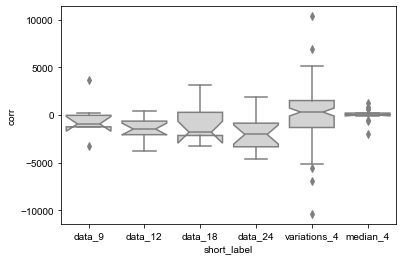

In [57]:
sns.boxplot(
    x='short_label', 
    y='corr', 
    data=master, 
    notch=True, 
    order=['data_9', 'data_12', 'data_18', 'data_24', 'variations_4','median_4'],
    color='lightgrey')

if save_images:
    export.export_image('{}/box_legacy.pdf'.format(outfolder))



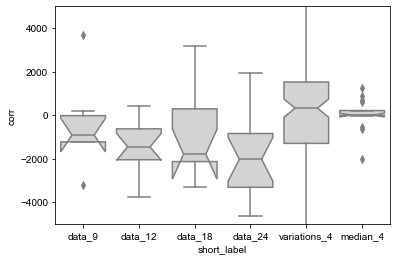

In [58]:
sns.boxplot(
    x='short_label', 
    y='corr', 
    data=master, 
    notch=True, 
    order=['data_9', 'data_12', 'data_18', 'data_24', 'variations_4','median_4'],
    color='lightgrey')
plt.ylim(-5000, 5000)


if save_images:
    export.export_image('{}/box_legacy_limit_to_5000.pdf'.format(outfolder))




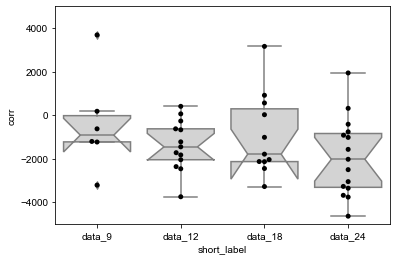

In [59]:
sns.boxplot(
    x='short_label', 
    y='corr', 
    data=master, 
    notch=True, 
    order=['data_9', 'data_12', 'data_18', 'data_24'],
    color='lightgrey')

sns.swarmplot(
    x='short_label', 
    y='corr', 
    data=master, 
    order=['data_9', 'data_12', 'data_18', 'data_24'],
    color='black')

plt.ylim(-5000, 5000)


if save_images:
    export.export_image('{}/box_legacy_limit_to_5000_swarm.pdf'.format(outfolder))

In [60]:
master

,tissue,older,corr,origin,short_label
0,Adrenal Gland,9.0,-1239.00,data,data_9
1,Adrenal Gland,12.0,-1230.75,data,data_12
2,Adrenal Gland,18.0,17.75,data,data_18
3,Adrenal Gland,24.0,-926.00,data,data_24
4,Brown adipose tissue,9.0,175.50,data,data_9
...,...,...,...,...,...
74,White adipose tissue,4.0,1256.50,median,median_4
75,White adipose tissue,9.0,783.25,median,median_9
76,White adipose tissue,12.0,-492.00,median,median_12
77,White adipose tissue,18.0,0.00,median,median_18


In [61]:
master[master['short_label']=='data_9']

,tissue,older,corr,origin,short_label
0,Adrenal Gland,9.0,-1239.00,data,data_9
4,Brown adipose tissue,9.0,175.50,data,data_9
8,Blood,9.0,NaN,data,data_9
12,Frontal cortex,9.0,NaN,data,data_9
16,Cerebellum,9.0,NaN,data,data_9
20,Esophagus,9.0,NaN,data,data_9
24,Gut epithelium,9.0,-3220.75,data,data_9
28,Heart,9.0,NaN,data,data_9
32,Kidney,9.0,3685.50,data,data_9
36,Large intestine,9.0,-1212.50,data,data_9


In [62]:
master.dropna(subset=['corr'])['short_label'].value_counts()

variations_12    120
variations_4     113
variations_9      93
variations_24     87
variations_18     87
median_12         17
median_9          16
median_4          16
data_24           15
median_18         15
median_24         15
data_12           13
data_18           11
data_9             6
Name: short_label, dtype: int64

In [63]:
master[master['short_label']=='data_9']

,tissue,older,corr,origin,short_label
0,Adrenal Gland,9.0,-1239.00,data,data_9
4,Brown adipose tissue,9.0,175.50,data,data_9
8,Blood,9.0,NaN,data,data_9
12,Frontal cortex,9.0,NaN,data,data_9
16,Cerebellum,9.0,NaN,data,data_9
20,Esophagus,9.0,NaN,data,data_9
24,Gut epithelium,9.0,-3220.75,data,data_9
28,Heart,9.0,NaN,data,data_9
32,Kidney,9.0,3685.50,data,data_9
36,Large intestine,9.0,-1212.50,data,data_9


In [64]:
master

,tissue,older,corr,origin,short_label
0,Adrenal Gland,9.0,-1239.00,data,data_9
1,Adrenal Gland,12.0,-1230.75,data,data_12
2,Adrenal Gland,18.0,17.75,data,data_18
3,Adrenal Gland,24.0,-926.00,data,data_24
4,Brown adipose tissue,9.0,175.50,data,data_9
...,...,...,...,...,...
74,White adipose tissue,4.0,1256.50,median,median_4
75,White adipose tissue,9.0,783.25,median,median_9
76,White adipose tissue,12.0,-492.00,median,median_12
77,White adipose tissue,18.0,0.00,median,median_18


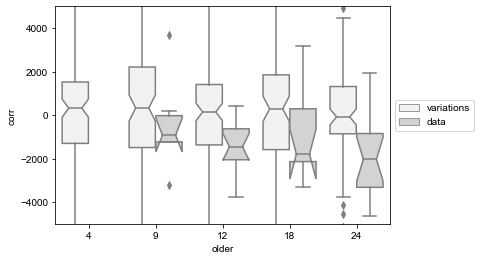

In [65]:
sns.boxplot(
    x='older', 
    y='corr', 
    data=master[master['origin'].isin(['variations', 'data'])], 
    notch=True, 
    hue='origin',
    order=[4, 9, 12, 18, 24],
    color='lightgrey',
    hue_order=['variations', 'data']
)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(-5000, 5000)



if save_images:
    export.export_image('{}/hue_box_limit_5000.pdf'.format(outfolder))



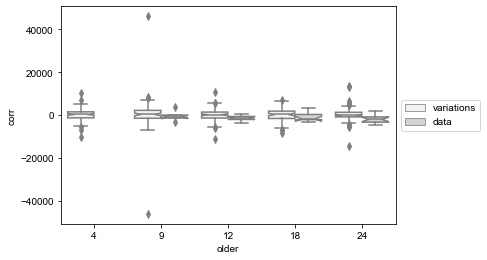

In [66]:
sns.boxplot(
    x='older', 
    y='corr', 
    data=master[master['origin'].isin(['variations', 'data'])], 
    notch=True, 
    hue='origin',
    order=[4, 9, 12, 18, 24],
    color='lightgrey',
    hue_order=['variations', 'data']
)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


if save_images:
    export.export_image('{}/hue_box.pdf'.format(outfolder))



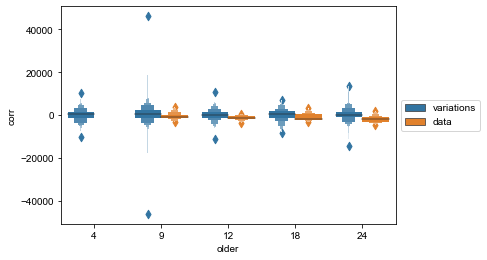

In [67]:
sns.boxenplot(
    x='older', 
    y='corr', 
    data=master[master['origin'].isin(['variations', 'data'])], 
    hue='origin',
    order=[4, 9, 12, 18, 24],
    hue_order=['variations', 'data']
)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

if save_images:
    export.export_image('{}/hue_boxen.pdf'.format(outfolder))



In [68]:
toy = pd.DataFrame(data={'pos': np.arange(1, 101)})

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


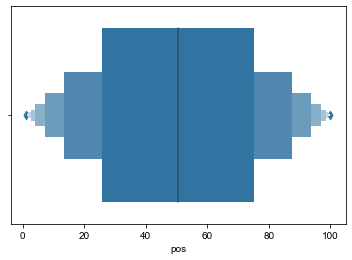

In [69]:
sns.boxenplot(toy['pos'])

if save_images:
    export.export_image('{}/plain_boxen.pdf'.format(outfolder))



In [70]:
for j in [9, 12, 18, 24]:
    print(
        
        j,
        mannwhitneyu(
            master[(master['origin']=='variations') & (master['older']==4)]['corr'],
            master[(master['origin']=='data') & (master['older']==j)]['corr'],
            alternative='two-sided'
        ))

9 MannwhitneyuResult(statistic=410.0, pvalue=0.0001458733564614803)
12 MannwhitneyuResult(statistic=1066.0, pvalue=0.46840841649938325)
18 MannwhitneyuResult(statistic=820.0, pvalue=0.3336632954316887)
24 MannwhitneyuResult(statistic=1266.0, pvalue=0.03519055256693965)


In [71]:
for j in [9, 12, 18, 24]:
    print(
        
        j,
        mannwhitneyu(
            master[(master['origin']=='variations') & (master['older']==j)]['corr'],
            master[(master['origin']=='data') & (master['older']==j)]['corr'],
            alternative='two-sided'
        ))

9 MannwhitneyuResult(statistic=334.0, pvalue=0.00016275595288671584)
12 MannwhitneyuResult(statistic=1152.0, pvalue=0.3905874986201078)
18 MannwhitneyuResult(statistic=616.0, pvalue=0.2795960223670739)
24 MannwhitneyuResult(statistic=981.0, pvalue=0.03413255477921196)
